### Exploratory Analysis ###

In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv("hot-100-current.csv")
data.head()

chart_week  current_week                              title     performer  \
0  2022-01-01             1    All I Want For Christmas Is You  Mariah Carey   
1  2022-01-01             2  Rockin' Around The Christmas Tree    Brenda Lee   
2  2022-01-01             3                   Jingle Bell Rock   Bobby Helms   
3  2022-01-01             4            A Holly Jolly Christmas     Burl Ives   
4  2022-01-01             5                         Easy On Me         Adele   

   last_week  peak_pos  wks_on_chart  
0        1.0         1            50  
1        2.0         2            44  
2        4.0         3            41  
3        5.0         4            25  
4        3.0         1            11

# Cleaning and Organizing Data #

The data set was organized in such a way that made analysis difficult. Each week's Billboard Top 100 was placed consecutively, from 202X-1958. This meant that analyzing chart performance would require us to iterate through the list to find each instance of a song, then organize those results into it's own dataset.

To fix this, we decided to pivot our data. The pivot resulted in the following structure for the dataset:

| Song Title | Artist | Week 1 of 1958 | Week 2 of 1958 | ... | Week 51 of 202X | Week 52 of 202X |
| --- | --- | --- | --- | --- | --- | --- |

This resulted in alot of `Nan` values, but we ultimately decided that these were MNAR values, as they tell us that a song was not in the charts on that week.

In [3]:
data["chart_week"] = pd.to_datetime(data["chart_week"])

# pivot table to better organize data
pivot = data.pivot_table(
    index=['title', 'performer'],
    columns='chart_week',
    values='current_week'
)

pivot.head()

chart_week                                                                     1958-08-04  \
title                                 performer                                             
"B" Girls                             Young And Restless                              NaN   
"Cherry Cherry" from Hot August Night Neil Diamond                                    NaN   
"Having A Party" Medley               The Ovations (Featuring Louis Williams)         NaN   
"Joy" Pt. I                           Isaac Hayes                                     NaN   
"Roots" Medley                        Quincy Jones                                    NaN   

chart_week                                                                     1958-08-11  \
title                                 performer                                             
"B" Girls                             Young And Restless                              NaN   
"Cherry Cherry" from Hot August Night Neil Diamond                                    NaN   
"Having A Party" Medley               The Ovations (Featuring Louis Williams)         NaN   
"Joy" Pt. I                           Isaac Hayes                                     NaN   
"Roots" Medley                        Quincy Jones                                    NaN   

chart_week                                                                     1958-08-18  \
title                                 performer                                             
"B" Girls                             Young And Restless                              NaN   
"Cherry Cherry" from Hot August Night Neil Diamond                                    NaN   
"Having A Party" Medley               The Ovations (Featuring Louis Williams)         NaN   
"Joy" Pt. I                           Isaac Hayes                                     NaN   
"Roots" Medley                        Quincy Jones                                    NaN   

chart_week                                                                     1958-08-25  \
title                                 performer                                             
"B" Girls                             Young And Restless                              NaN   
"Cherry Cherry" from Hot August Night Neil Diamond                                    NaN   
"Having A Party" Medley               The Ovations (Featuring Louis Williams)         NaN   
"Joy" Pt. I                           Isaac Hayes                                     NaN   
"Roots" Medley                        Quincy Jones                                    NaN   

chart_week                                                                     1958-09-01  \
title                                 performer                                             
"B" Girls                             Young And Restless                              NaN   
"Cherry Cherry" from Hot August Night Neil Diamond                                    NaN   
"Having A Party" Medley               The Ovations (Featuring Louis Williams)         NaN   
"Joy" Pt. I                           Isaac Hayes                                     NaN   
"Roots" Medley                        Quincy Jones                                    NaN   

chart_week                                                                     1958-09-08  \
title                                 performer                                             
"B" Girls                             Young And Restless                              NaN   
"Cherry Cherry" from Hot August Night Neil Diamond                                    NaN   
"Having A Party" Medley               The Ovations (Featuring Louis Williams)         NaN   
"Joy" Pt. I                           Isaac Hayes                                     NaN   
"Roots" Medley                        Quincy Jones                                    NaN   

chart_week                                                                     1958-09-1

# Billboard Streak Statistics #

- **Average Streak:** around 12 weeks
- **Longest Streak:** Glass Animals - "Heat Wave" at 92 weeks

# On Outliers #

The dataset is highly Right-Skewed. While the maximum streak sits at 92 weeks, 75% of the data is below 17. However, this desparity is ultimately useful because it can help with analyzing a song's longevity. Billboard charts are prone to what are referred to as **"One Hit Wonders"**—artists who get on the charts only once, and whoses songs don't stick in cultural memory.

Text(0, 0.5, '# of Songs')

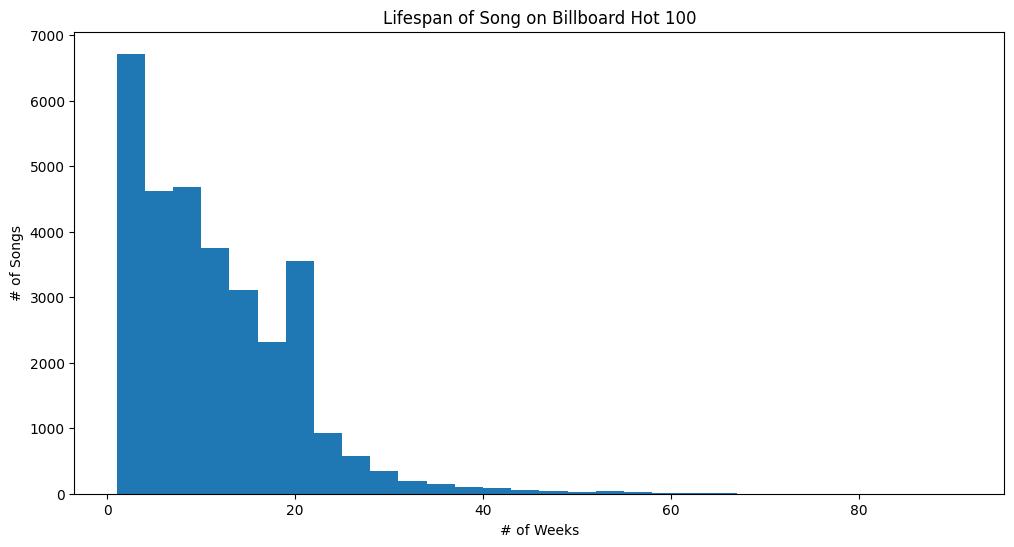

In [4]:
weeks_on_chart = pivot.notna().sum(axis=1)

# Add it as a new column in the pivot table
pivot["total_weeks_on_chart"] = weeks_on_chart

plt.figure(figsize=(12, 6))

# Show result
pivot["total_weeks_on_chart"].plot(kind="hist",
                                   bins=30)
plt.title("Lifespan of Song on Billboard Hot 100")
plt.xlabel("# of Weeks")
plt.ylabel("# of Songs")

In [5]:
print(weeks_on_chart.describe())

max_weeks = pivot.reset_index()
max_weeks = max_weeks[max_weeks["total_weeks_on_chart"] == weeks_on_chart.max()]

print(f"Longest Billboard Streak: {max_weeks["performer"]} @ {weeks_on_chart.max()} weeks ")

count    31344.000000
mean        10.961811
std          8.522820
min          1.000000
25%          4.000000
50%          9.000000
75%         16.000000
max         91.000000
dtype: float64
Longest Billboard Streak: 10077    Glass Animals
Name: performer, dtype: object @ 91 weeks 


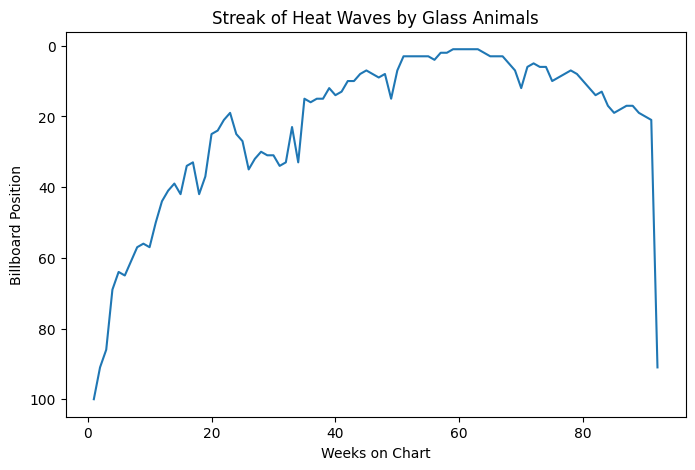

In [6]:
# Extract the row for that song
track = pivot.loc[("Heat Waves", "Glass Animals")].dropna()

# Re-number weeks from 1 to N
track.index = range(1, len(track)+1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(track)
plt.gca().invert_yaxis()  # rank 1 at the top
plt.title(f"Streak of Heat Waves by Glass Animals")
plt.xlabel("Weeks on Chart")
plt.ylabel("Billboard Position")
plt.show()

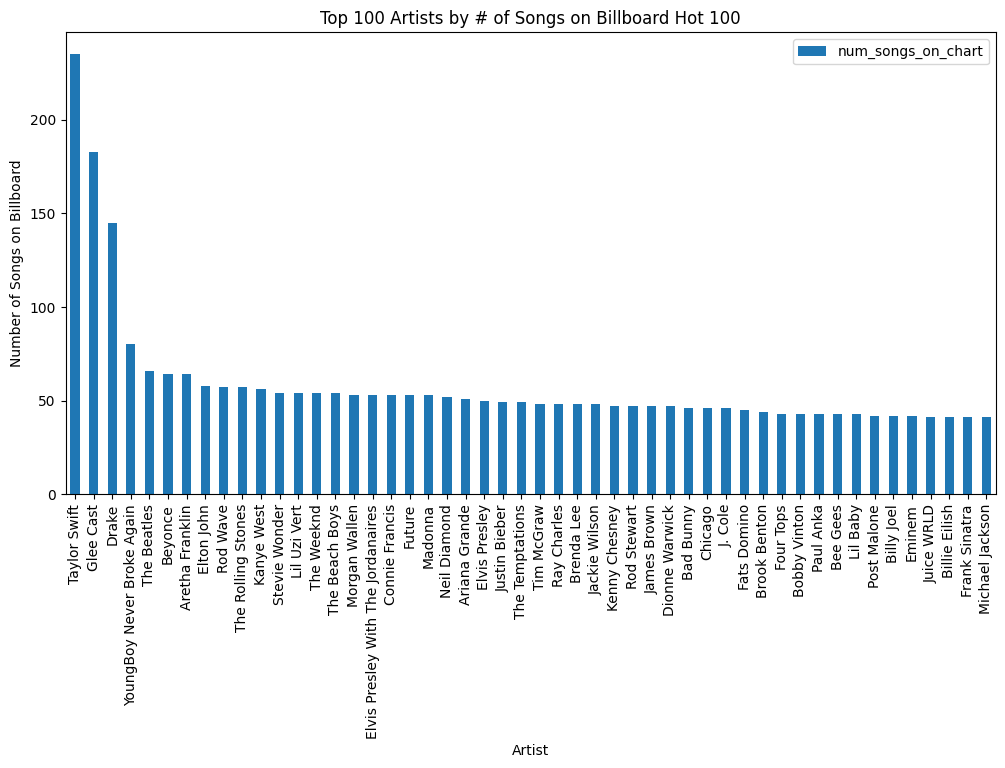

In [7]:
# Reset pivot index
pivot_reset = pivot.reset_index()

# Count distinct songs per performer
songs_per_performer = pivot_reset.groupby("performer")["title"].nunique()

# Convert Series to DataFrame and rename column
songs_per_performer = songs_per_performer.reset_index()
songs_per_performer = songs_per_performer.rename(columns={"title": "num_songs_on_chart"})

# Take top 100 performers
top100 = songs_per_performer.sort_values("num_songs_on_chart", ascending=False).head(50)

# Plot
top100.plot(x="performer", y="num_songs_on_chart", kind="bar", figsize=(12, 6))
plt.xticks(rotation=90)
plt.xlabel("Artist")
plt.ylabel("Number of Songs on Billboard")
plt.title("Top 100 Artists by # of Songs on Billboard Hot 100")
plt.show()

# Example: Tracking Bob Dylan's Chart Peformance By Song #

We chose Bob Dylan as an example because he had relavitely few hit singles when compared to a more sensational artist, which makes this specific visualization easier. The result shows a pattern of rises and falls, which falls in line with what we expected to observe for the performance of a song.

In [8]:
bob = pivot[
    pivot.index.get_level_values("performer").str.contains("bob dylan", case=False)
]
bob = bob.drop(columns="total_weeks_on_chart")

aligned = {}

for (title, performer), row in bob.iterrows():

    # Drop weeks where the song wasn't on the chart
    track = row.dropna().sort_index()
    
    # Re-number from 1 to N
    track.index = range(1, len(track) + 1)
    
    aligned[(title, performer)] = track

aligned_df = pd.DataFrame(aligned)

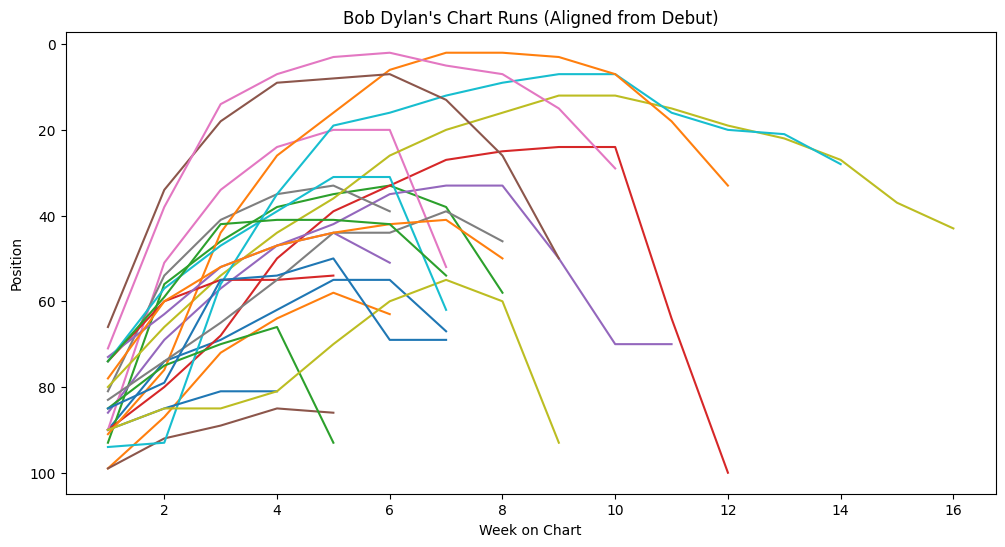

In [9]:
plt.figure(figsize=(12, 6))

for col in aligned_df:
    plt.plot(aligned_df.index, aligned_df[col], label=col[0])

plt.gca().invert_yaxis()
plt.title("Bob Dylan's Chart Runs (Aligned from Debut)")
plt.xlabel("Week on Chart")
plt.ylabel("Position")
plt.show()

In [ ]:
# since spotify took down their api to get song information, we had to resort to using a csv of 1.2+ million spotify songs in which the track_features api
# we were planning on using was already run and had the results stored.

spotify_api_data = pd.read_csv("tracks_features.csv")
spotify_api_data = spotify_api_data.drop(columns=["id", "album_id", "artist_ids", "track_number", "disc_number", "year", "release_date", "mode", "instrumentalness"])
spotify_api_data.head()


name                      album  \
0                Testify  The Battle Of Los Angeles   
1        Guerrilla Radio  The Battle Of Los Angeles   
2       Calm Like a Bomb  The Battle Of Los Angeles   
3              Mic Check  The Battle Of Los Angeles   
4  Sleep Now In the Fire  The Battle Of Los Angeles   

                        artists  explicit  danceability  energy  key  \
0  ['Rage Against The Machine']     False         0.470   0.978    7   
1  ['Rage Against The Machine']      True         0.599   0.957   11   
2  ['Rage Against The Machine']     False         0.315   0.970    7   
3  ['Rage Against The Machine']      True         0.440   0.967   11   
4  ['Rage Against The Machine']     False         0.426   0.929    2   

   loudness  speechiness  acousticness  liveness  valence    tempo  \
0    -5.399       0.0727       0.02610    0.3560    0.503  117.906   
1    -5.764       0.1880       0.01290    0.1550    0.489  103.680   
2    -5.424       0.4830       0.02340    0.1220    0.370  149.749   
3    -5.830       0.2370       0.16300    0.1210    0.574   96.752   
4    -6.729       0.0701       0.00162    0.0789    0.539  127.059   

   duration_ms  time_signature  
0       210133             4.0  
1       206200             4.0  
2       298893             4.0  
3       213640             4.0  
4       205600             4.0

In [11]:
hot = data.copy()
tracks = spotify_api_data.copy()

# normalize strings for matching
hot_norm = hot.assign(title_norm=hot["title"].str.lower().str.strip(), performer_norm=hot["performer"].str.lower().str.strip())
tracks_norm = tracks.assign(
    title_norm=tracks["name"].str.lower().str.strip(),
    artists_norm=tracks["artists"].str.lower(),
)

# match on title, then require the performer to appear in the artists list
title_matches = hot_norm.merge(tracks_norm[["title_norm", "artists_norm"]], on="title_norm", how="inner")

mask = []
for i in range(len(title_matches)):
    performer = title_matches.loc[i, "performer_norm"]
    artists = title_matches.loc[i, "artists_norm"]
    mask.append(performer in artists)

row_matches = title_matches[mask]
matches = len(row_matches)
total_hot = len(hot)
percent = (matches / total_hot) * 100

print(f"Songs from hot-100-current found in tracks_features: {matches} out of {total_hot} ({percent:.1f}%).")

Songs from hot-100-current found in tracks_features: 173625 out of 343600 (50.5%).


In [12]:
# after looking at the csv files I noticed a common pattern of the billboard hot 100 artists being labeled with the terms
# "featured" and a "&" when there were multiple artists. this was causing certin tracks to not register so I am now going to fix that.

hot_clean = hot.assign(
    title_norm=hot["title"].str.lower().str.strip().str.split(r"\s+featuring\s+", regex=True).str[0].str.split(" & ").str[0], 
    performer_norm=hot["performer"].str.lower().str.strip().str.split(r"\s+featuring\s+", regex=True).str[0].str.split(" & ").str[0])

tracks_clean = tracks.assign(
    title_norm=tracks["name"].str.lower().str.strip().str.split(r"\s+featuring\s+", regex=True).str[0].str.split(" & ").str[0],
    artists_norm=tracks["artists"].str.lower())

# match on title, then require performer to appear in artists list
title_matches_clean = hot_clean.merge(tracks_clean[["title_norm", "artists_norm"]], on="title_norm", how="inner")

mask = []
for i in range(len(title_matches_clean)):
    performer = title_matches_clean.loc[i, "performer_norm"]
    artists = title_matches_clean.loc[i, "artists_norm"]
    mask.append(performer in artists)

row_matches_clean = title_matches_clean[mask]
matches_clean = len(row_matches_clean)
percent_clean = (matches_clean / len(hot)) * 100

print(f"After stripping 'featuring' and ' & ': {matches_clean} out of {len(hot)} ({percent_clean:.1f}%)")

After stripping 'featuring' and ' & ': 181583 out of 343600 (52.8%)


In [13]:
# merge again with full track fields, then filter to the same matched rows
title_matches_full = hot_clean.merge(
    tracks_clean[
        [
            "title_norm",
            "name",
            "album",
            "artists",
            "explicit",
            "danceability",
            "energy",
            "key",
            "loudness",
            "speechiness",
            "acousticness",
            "liveness",
            "valence",
            "tempo",
            "duration_ms",
            "time_signature",
            "artists_norm",
        ]
    ],
    on="title_norm",
    how="inner",
)

mask_full = []
for i in range(len(title_matches_full)):
    performer = title_matches_full.loc[i, "performer_norm"]
    artists = title_matches_full.loc[i, "artists_norm"]
    mask_full.append(performer in artists)

combined_df = title_matches_full[mask_full][
    [
        "name",
        "performer",
        "album",
        "current_week",
        "last_week",
        "wks_on_chart",
        "peak_pos",
        "chart_week",
        "explicit",
        "danceability",
        "energy",
        "key",
        "loudness",
        "speechiness",
        "acousticness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "time_signature"
    ]
]

print(f"Combined matched rows: {len(combined_df)}")
combined_df = combined_df.reset_index(drop=True)
combined_df.sample(n=5)

Combined matched rows: 181583


name            performer  \
121510                Stroke You Up       Changing Faces   
8559    Subterranean Homesick Blues            Bob Dylan   
168209                 Transportin'          Kodak Black   
32009                     Piano Man           Billy Joel   
63603                   He's so Shy  The Pointer Sisters   

                                                album  current_week  \
121510                                R'N'B Slow Jams            18   
8559                          The Essential Bob Dylan            46   
168209  Project Baby 2: All Grown Up (Deluxe Edition)            62   
32009                       50 Classic Rock Favorites            51   
63603            Special Things (Bonus Track Version)            37   

        last_week  wks_on_chart  peak_pos chart_week  explicit  danceability  \
121510       23.0             4        18 1994-08-20     False         0.729   
8559         39.0             8        39 1965-05-22     False         0.542   
168209       55.0             6        46 2017-10-14     False         0.803   
32009        61.0             5        51 1974-03-23     False         0.334   
63603        26.0            21         3 1980-12-13     False         0.871   

        energy  key  loudness  speechiness  acousticness  liveness  valence  \
121510   0.517    3    -8.409       0.0310        0.1110    0.0437    0.541   
8559     0.776    4    -6.600       0.0699        0.5870    0.3570    0.687   
168209   0.670   10    -5.023       0.0531        0.0398    0.1230    0.301   
32009    0.472    0    -8.792       0.0277        0.6000    0.3170    0.431   
63603    0.736    0    -7.896       0.0675        0.2200    0.0894    0.967   

          tempo  duration_ms  time_signature  
121510  131.437       352240             4.0  
8559    173.795       138427             4.0  
168209   94.050       169531             4.0  
32009   179.167       336093             3.0  
63603   115.149       218320             4.0

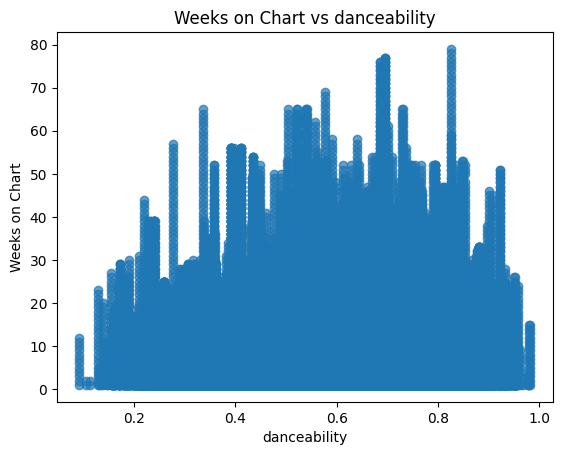

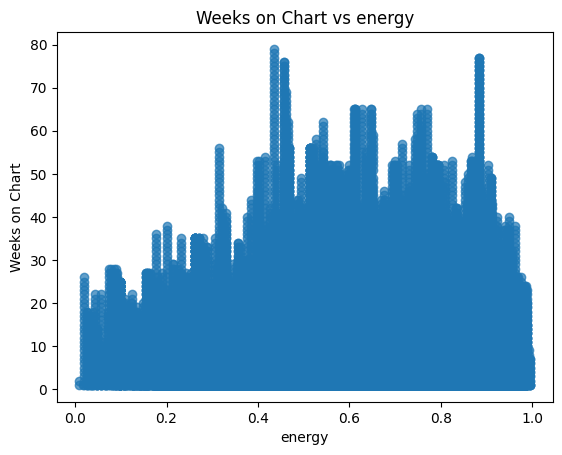

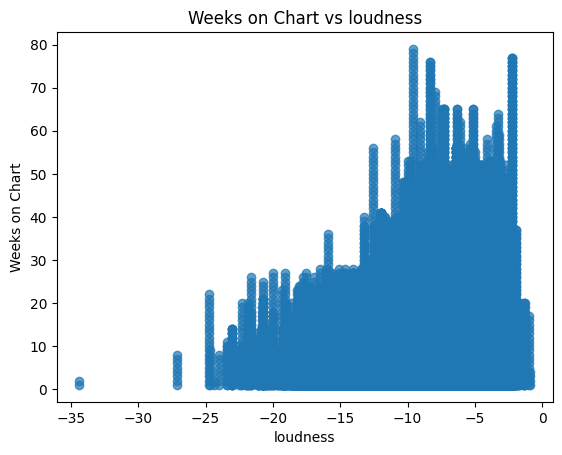

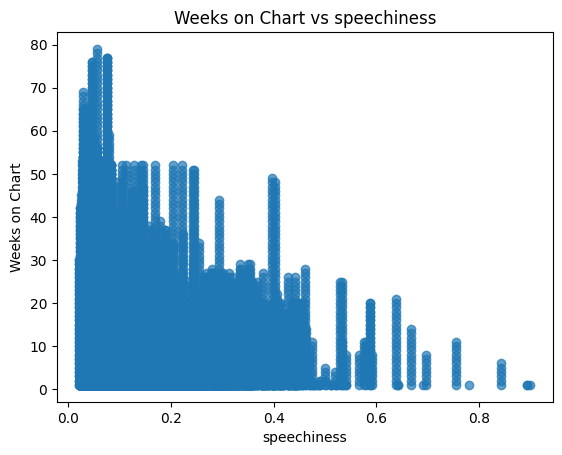

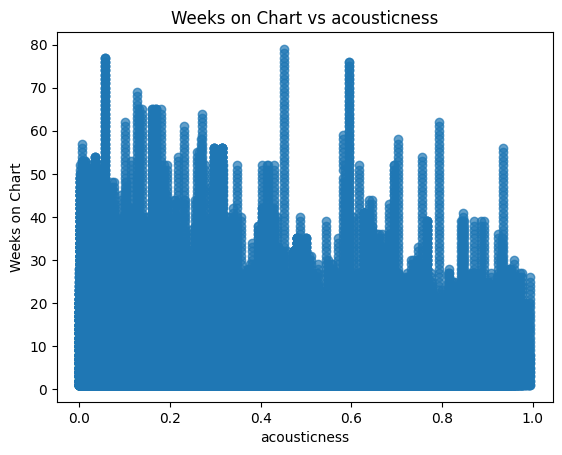

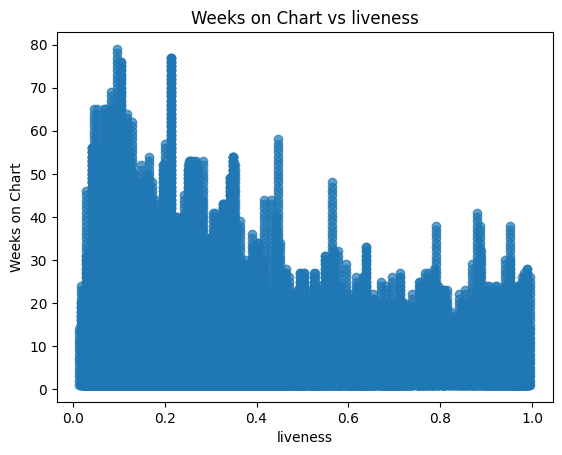

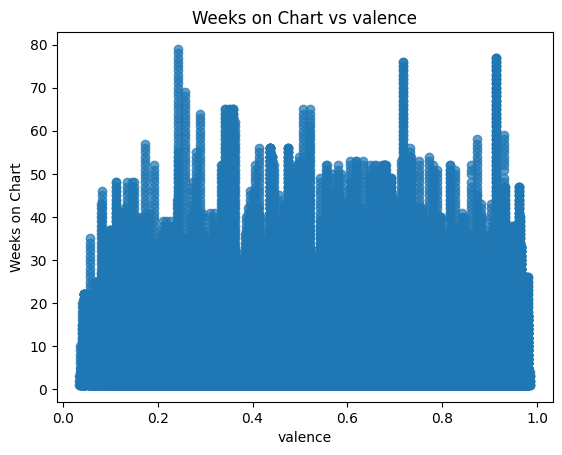

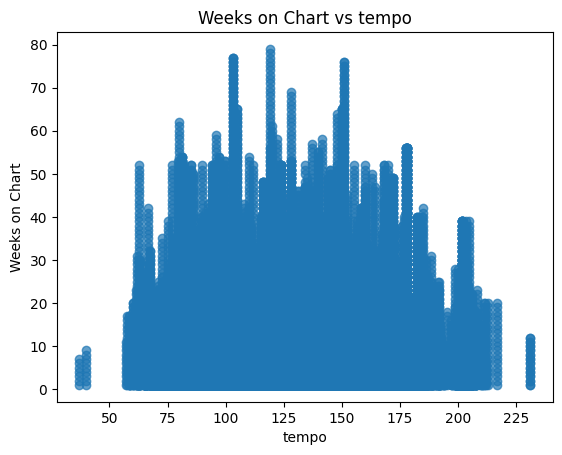

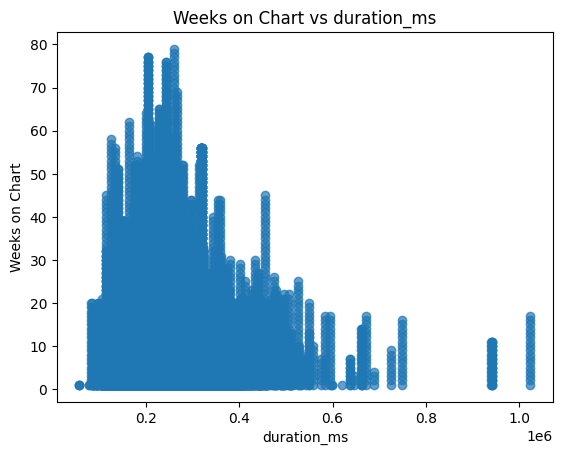

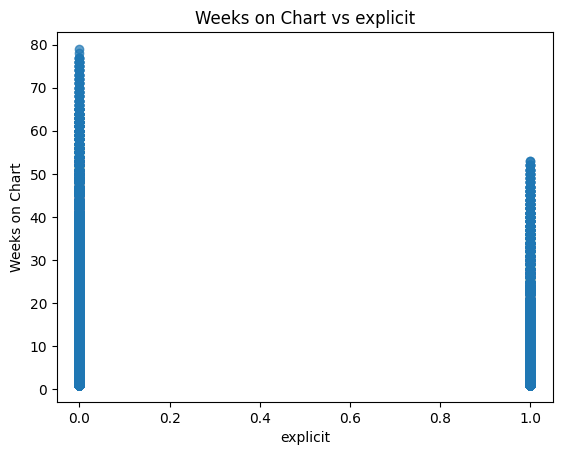

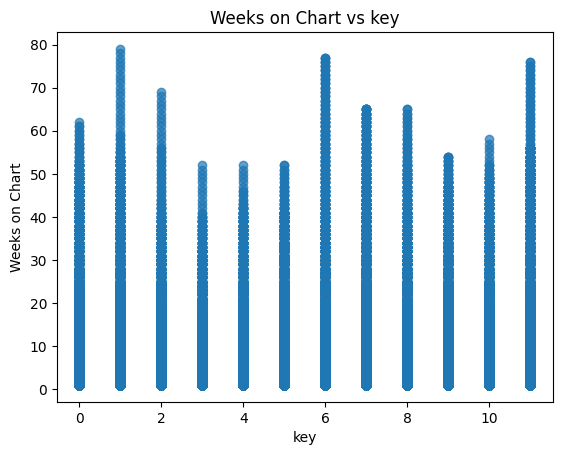

In [14]:
predictor_list = ["danceability", "energy", "loudness", "speechiness", "acousticness", "liveness", "valence", "tempo", "duration_ms", "explicit", "key"]

for col in predictor_list:
    data = combined_df[[col, "wks_on_chart"]].dropna()
    plt.figure()
    plt.scatter(data[col], data["wks_on_chart"], marker="o", alpha=0.7)
    plt.title(f"Weeks on Chart vs {col}")
    plt.xlabel(col)
    plt.ylabel("Weeks on Chart")
    plt.show()